In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image
from keras.optimizers import Adam

In [ ]:
#dont run

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)



training_set = train_datagen.flow_from_directory('/content/drive/My Drive/joshi_hand/hand/train',
                                                 target_size = (64, 64),
                                                 batch_size = 8,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/joshi_hand/hand/test',
                                            target_size = (64, 64),
                                            batch_size = 8,
                                            class_mode = 'categorical',
                                            shuffle = False)

training_set.class_indices
test_set.class_indices

print(test_set)

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_______________________________________________________

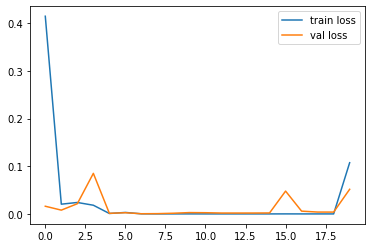

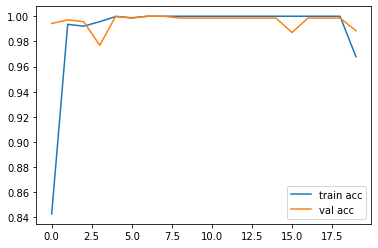

<Figure size 432x288 with 0 Axes>

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [64, 64]


from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

train_path = '/content/drive/My Drive/joshi_hand/hand/train'
valid_path = '/content/drive/My Drive/joshi_hand/hand/test'

# add preprocessing layer to the front of VGG
base = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in base.layers:
  layer.trainable = True
 
  # useful for getting number of classes
folders = glob('/content/drive/My Drive/joshi_hand/hand/train/*')

dropout1 = Dropout(0.5)
x = base.output
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x = dropout1(x) 
x=Dense(512,activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=base.input, outputs=prediction)

# view the structure of the model
model.summary()



opt = keras.optimizers.Adam(learning_rate=0.0001)
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)



training_set = train_datagen.flow_from_directory('/content/drive/My Drive/joshi_hand/hand/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/joshi_hand/hand/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

filepath="/content/drive/My Drive/joshi_hand/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath, save_weights_only=True, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  use_multiprocessing=True,
  workers=6,  
  steps_per_epoch=len(training_set)*2,
  validation_steps=len(test_set)*2,
  callbacks=[checkpointer,cb]
)

print(cb.logs)
print(sum(cb.logs))


# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')



Epoch 00028: val_accuracy improved from 0.97306 to 0.97811, saving model to /content/drive/My Drive/joshi_hand/weights-28-0.9781.hdf5
750/750 [==============================] - 47s 63ms/step - loss: 0.0113 - accuracy: 0.9958 - val_loss: 0.0622 - val_accuracy: 0.9781